## Notebook pour voir les résultats des DMPs : Pour GESRes Jester dataset

In [17]:
from video import Video
import visualize
from utils import landmarks_2_table
import mediapipe as mp
import os
import cv2
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from IPython.display import clear_output, display
import random



In [18]:
import numpy as np

class DMPVector:
    def __init__(self, n_basis: int = 20):
        self.n_basis = n_basis # number of gaussians
        self.centers = None
        self.widths = None
        self.W = None       # (n_basis, D)
        self.y0 = None      # (D,)
        self.g = None       # (D,)
        self.T_train = None

    def _basis_functions(self, T: int):
        t = np.linspace(0.0, 1.0, T)
        self.centers = np.linspace(0.0, 1.0, self.n_basis)
        self.widths = np.ones(self.n_basis) * (self.n_basis ** 2)
        psi = np.exp(-self.widths * (t[:, None] - self.centers[None, :])**2)
        return psi, t

    def fit(self, Y: np.ndarray):
        T, D = Y.shape
        self.T_train = T
        self.y0 = Y[0].copy()
        self.g  = Y[-1].copy()

        psi, t = self._basis_functions(T)   # (T, n_basis)
        Y_lin = self.y0 + np.outer(t, (self.g - self.y0))   # (T, D)
        F_target = Y - Y_lin                                # (T, D)

        psi_sum  = np.sum(psi, axis=1, keepdims=True) + 1e-10
        psi_norm = psi / psi_sum                           # (T, n_basis)

        self.W, _, _, _ = np.linalg.lstsq(psi_norm, F_target, rcond=None)

    def fit_multi(self, Y_batch: np.ndarray):
        N, T, D = Y_batch.shape
        self.T_train = T

        psi, t = self._basis_functions(T)           # (T, n_basis)
        psi_sum  = np.sum(psi, axis=1, keepdims=True) + 1e-10
        psi_norm = psi / psi_sum                    # (T, n_basis)

        F_list = []
        y0_all = []
        g_all  = []

        for i in range(N):
            Y = Y_batch[i]
            y0_i = Y[0].copy()
            g_i  = Y[-1].copy()

            y0_all.append(y0_i)
            g_all.append(g_i)

            Y_lin_i = y0_i + np.outer(t, (g_i - y0_i))   # (T, D)
            F_i     = Y - Y_lin_i                        # (T, D)
            F_list.append(F_i)

        F_all = np.concatenate(F_list, axis=0)           # (N*T, D)
        Psi_big = np.tile(psi_norm, (N, 1))              # (N*T, n_basis)

        self.W, _, _, _ = np.linalg.lstsq(Psi_big, F_all, rcond=None)

        self.y0 = np.mean(np.stack(y0_all, axis=0), axis=0)
        self.g  = np.mean(np.stack(g_all,  axis=0), axis=0)

    def rollout(self, T: int = None, amplitude_scale: float = 1.0) -> np.ndarray:
        if T is None:
            T = self.T_train

        psi, t = self._basis_functions(T)
        psi_sum  = np.sum(psi, axis=1, keepdims=True) + 1e-10
        psi_norm = psi / psi_sum

        F = psi_norm @ self.W * amplitude_scale
        Y_lin = self.y0 + np.outer(t, (self.g - self.y0))
        Y = Y_lin + F
        return Y


In [19]:
import joblib

gesture_dmps = joblib.load("gesture_dmps.joblib")
print(gesture_dmps.keys())


dict_keys(['one', 'finger', 'cup', 'knock', 'clasp', 'hold', 'punch', 'point', 'wave', 'show', 'soft', 'present', 'hand', 'Drumming Fingers', 'Pushing Two Fingers Away', 'Sliding Two Fingers Down', 'Stop Sign', 'Swiping Up', 'Turning Hand Counterclockwise', 'Zooming Out With Two Fingers', 'Pulling Hand In', 'Rolling Hand Backward', 'Sliding Two Fingers Left', 'Swiping Down', 'Thumb Down', 'Zooming In With Full Hand', 'Pulling Two Fingers In', 'Rolling Hand Forward', 'Sliding Two Fingers Right', 'Swiping Left', 'Thumb Up', 'Zooming In With Two Fingers', 'Pushing Hand Away', 'Shaking Hand', 'Sliding Two Fingers Up', 'Swiping Right', 'Turning Hand Clockwise', 'Zooming Out With Full Hand'])


In [20]:
KEYPOINTS = [0, 2, 5, 7, 8, 9, 10, 11, 12] + list(range(13, 23))



In [21]:
def vec_to_skeleton(Y_vec: np.ndarray, n_points=21) -> np.ndarray:
    """
    Convertit un vecteur DMP en squelette 2D avec n_points articulations.
    Y_vec : (T, 2*n_points)
    -> (T, n_points, 2)
    """
    T, D = Y_vec.shape
    assert D == 2 * n_points, f"Expected {2*n_points} dims, got {D}"
    return Y_vec.reshape(T, n_points, 2)



In [22]:
def rotate_skeleton_xy(seq: np.ndarray) -> np.ndarray:
    """
    Prend un tableau (T, J, 2) et échange les colonnes x et y.
    Retourne un nouveau tableau (ne modifie pas l'original).
    """
    rotated = seq.copy()
    pts = rotated.copy()
    rotated[:, :, 0] = pts[:, :, 1]  # nouveau x = ancien y
    rotated[:, :, 1] = pts[:, :, 0]  # nouveau y = ancien x
    return rotated



In [33]:
EDGES = [

    # --- Head connections ---
    (0, 1),   # nose -> right eye
    (0, 2),   # nose -> left eye
    (1, 3),   # right eye -> right ear
    (2, 4),   # left eye -> left ear
    (5, 6),   # mouth right -> mouth left
    (3, 5),   # nose -> mouth right
    (4, 6),   # nose -> mouth left

    # --- Shoulders ---
    (7, 8),   # right shoulder -> left shoulder

    # --- Right arm ---
    (7, 9),   # right shoulder -> right elbow
    (9, 11),  # right elbow -> right wrist

    # Right hand (MediaPipe knuckles)
    (11, 13), # wrist -> right pinky knuckle
    (11, 15), # wrist -> right index knuckle
    (11, 17), # wrist -> right thumb knuckle

    # small knuckle triangles (optional)
    (13, 15),
    (15, 17),

    # --- Left arm ---
    (8, 10),  # left shoulder -> left elbow
    (10, 12), # left elbow -> left wrist

    # Left hand knuckles
    (12, 14), # wrist -> left pinky
    (12, 16), # wrist -> left index
    (12, 18), # wrist -> left thumb

    # small knuckle triangles (optional)
    (14, 16),
    (16, 18),

    # --- Torso / hips ---
    (7, 19),  # right shoulder -> right hip
    (8, 20),  # left shoulder -> left hip
    (19, 20), # hips together
]

def plot_stickman_frame2(ax, norm_seq, frame_idx: int):
    pts = norm_seq[frame_idx]          # (33, 2)
    visible = ~np.isnan(pts).any(axis=1)

    ax.cla()   # efface le contenu des axes

    # segments
    for i, j in EDGES:
        if i < pts.shape[0] and j < pts.shape[0]:
            if visible[i] and visible[j]:
                x_vals = [pts[i, 0], pts[j, 0]]
                y_vals = [pts[i, 1], pts[j, 1]]
                ax.plot(x_vals, y_vals, "-")

    # points visibles
    x_vis = pts[visible, 0]
    y_vis = pts[visible, 1]
    ax.scatter(x_vis, y_vis, c="red")

    # indices
    for idx in np.where(visible)[0]:
        x, y = pts[idx]
        ax.text(x, y, str(idx), fontsize=7)

    ax.set_title(f"Stickman (frame {frame_idx})")
    ax.axis("equal")
    ax.grid(True)

In [24]:
T=50
def plot_stickman(label):
  fig, ax = plt.subplots(figsize=(6, 6))
  for i in range(0, min(T,50)):
    if label not in gesture_dmps:
        raise ValueError(f"Label '{label}' pas trouvé dans gesture_dmps.")

    dmp = gesture_dmps[label]
    Y = dmp.rollout(T=T)          # (T, 32)
    skel_seq = vec_to_skeleton(Y, n_points=21)

    plot_stickman_frame2(ax, rotate_skeleton_xy(skel_seq), frame_idx=i)
    clear_output(wait=True)  # efface la sortie de la cellule
    display(fig)             # ré-affiche la figure
    plt.pause(0.05)          # petit délai pour voir l'update

  plt.close(fig)

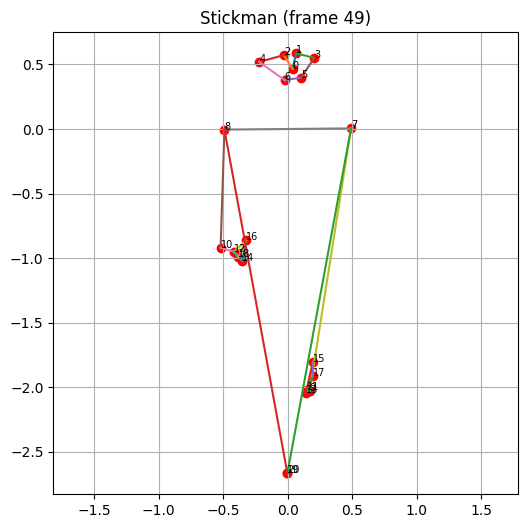

In [34]:
# plot_stickman("one")
# plot_stickman("finger")
# plot_stickman("cup")
# plot_stickman("knock")
# plot_stickman("clasp")
# plot_stickman("hold")
# plot_stickman("punch")
# plot_stickman("point")
plot_stickman("Thumb Up")
# plot_stickman("show")
# plot_stickman("soft")
# plot_stickman("present")
# plot_stickman("hand")